In [1]:
### This file does a RZ gate (1 parameter, 1 qubit) with X,Y control
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils
using Flux
using CairoMakie

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;

In [3]:
# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}([1 0; 0 1]),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 im; -im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)
const a = [0 1; 0 0]
const ad = transpose(a);
excitation(theta) = exp(-im/2 * theta * Paulis["Z"]);


H_drives = [
     Paulis["X"],Paulis["Y"]
]
system = QuantumSystem(H_drives);
t_f = 10* ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
n_controls=1
n_qubits=1;
Δt = times[2] - times[1]

0.2

In [4]:
N = 11
### Generate Initial Trajectories 
PICO_max_iter = 100

# Shape the cost function with weights on states and controls
Q = 100.
R =1e-2

a_bound = 1.0
dda_bound = 1.0

ops = IpoptOptions()
ops.print_info_string = "yes"
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1.0 ##down
ops.print_level = 0

p_op = PiccoloOptions()
p_op.verbose=false
p_op.pade_order=10
p_op.free_time=false
p_op.timesteps_all_equal=true


true

In [5]:
probs = [UnitarySmoothPulseProblem(
    system,
    excitation(theta),
    n_steps,
    Δt;
    ipopt_options = ops,
    piccolo_options = p_op,
    a_bound=a_bound,
    dda_bound=dda_bound,
    Q=Q,
    R=R
) for theta in range(0,2*pi,N)]
    
p = UnitaryDirectSumProblem(
    probs,
    1-1e-4;
    Q=Q,
    R=R
);
solve!(p, max_iter=PICO_max_iter)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



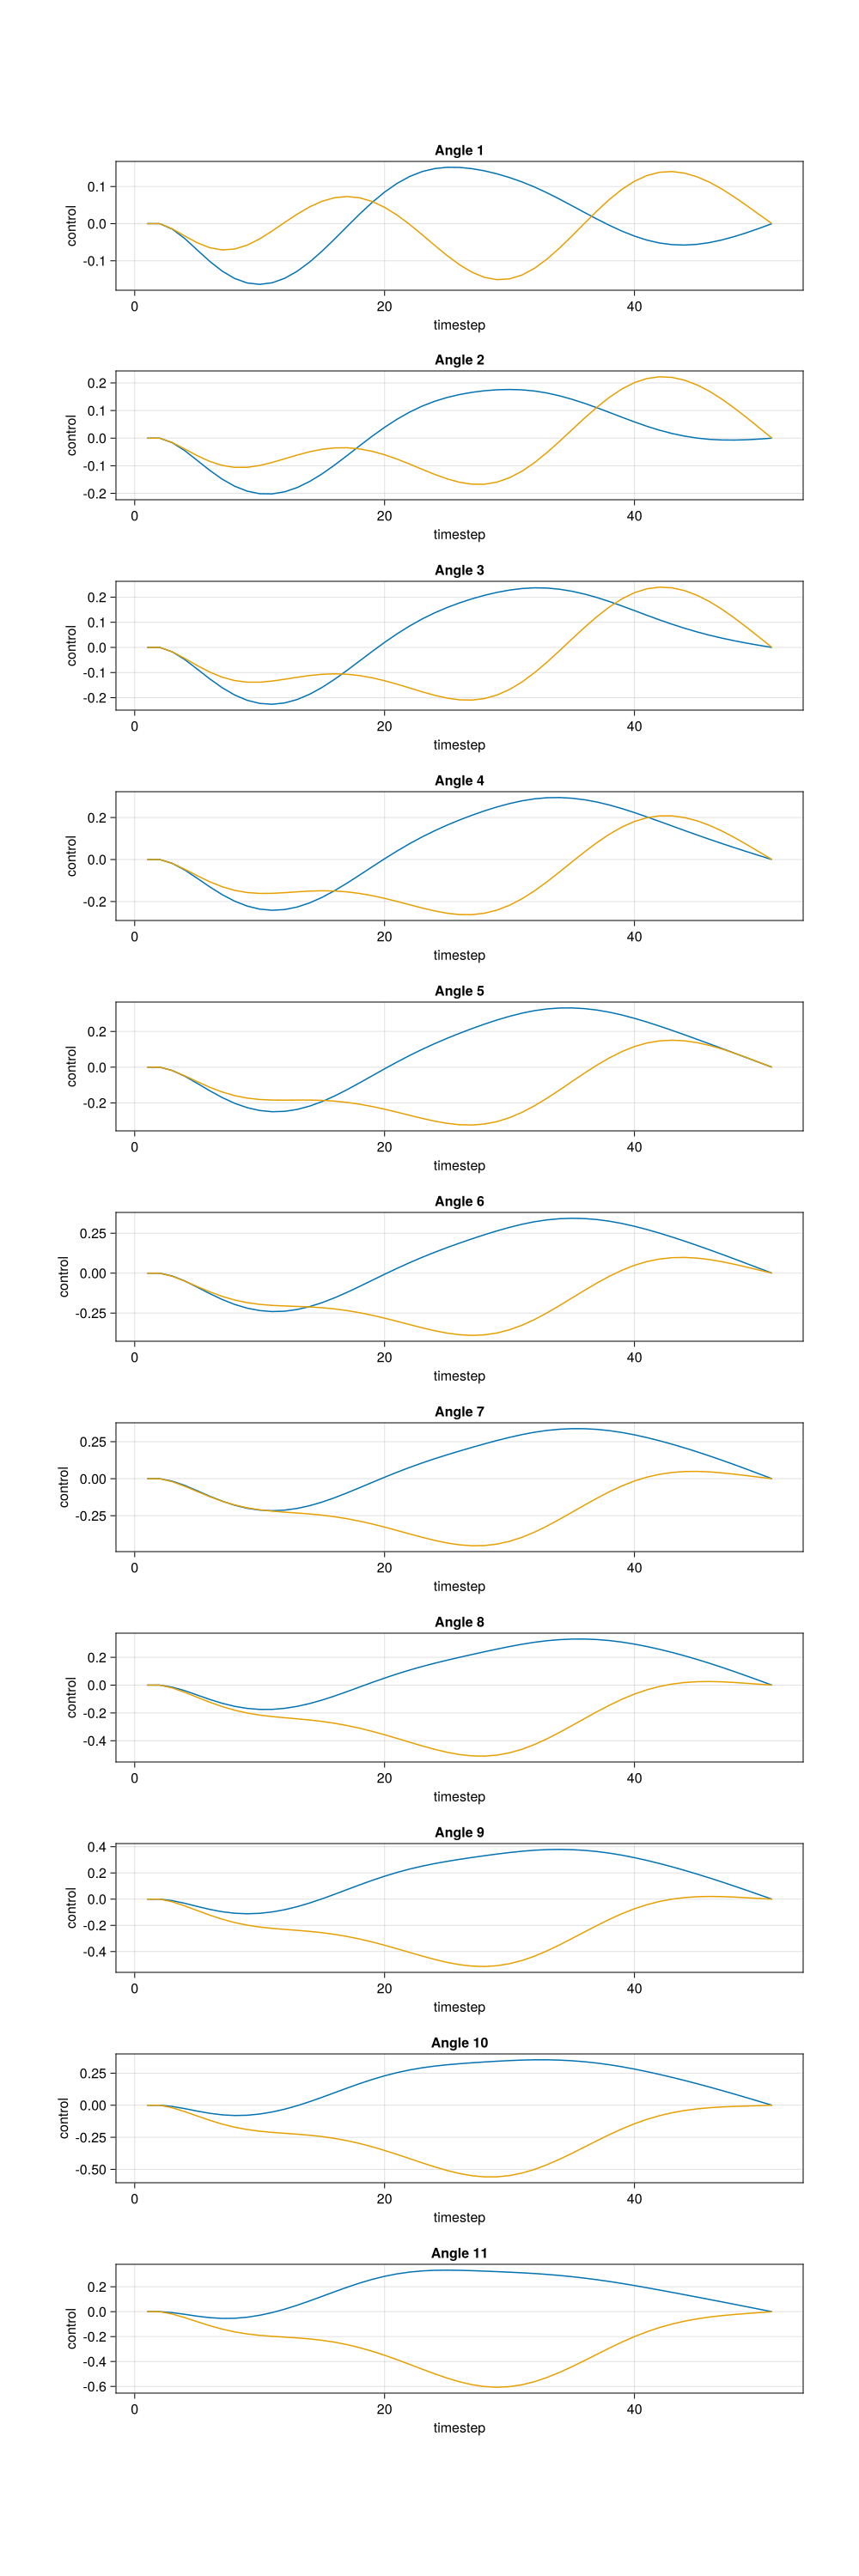

In [6]:
fig = Figure(resolution=(1000, 3000))
for (i,v) in enumerate(range(0,2*pi,N))
    ax =  Axis(fig[i,1], width = 800, height = 150, title="Angle "*string(i),xlabel="timestep",ylabel="control")
    lines!(ax,1:n_steps,p.trajectory[Symbol("a"*string(i))][1,:])
    lines!(ax,1:n_steps,p.trajectory[Symbol("a"*string(i))][2,:])
end
fig

In [7]:
controls = [p.trajectory[Symbol("a"*string(i))] for i in 1:N] 
x = operator_to_iso_vec( Matrix{Complex}([1.0 0.0; 0.0 1.0]))
for (i,theta) in enumerate(range(0,2*pi,N))
    rollout_states = unitary_rollout(x,controls[i],Δt,system)
    println(unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(excitation(theta))))
end

4.3305064418408534e-5
1.3507181674143887e-5
3.7738546551091545e-6
2.0893348183781413e-6
8.307745352986728e-6
1.0167040221276125e-5
2.8004938103620702e-5
1.8888891810675545e-6
5.134529272199373e-6
4.136591735814932e-8
9.857023570880585e-5


In [8]:
x_train = Vector{Vector{Float32}}()
y_train = Vector{Vector{Float32}}()
for (i,v) in enumerate(range(0,2*pi,N))
    for t in range(1,n_steps-1)
    push!(x_train,vcat(p.trajectory[Symbol(string(:Ũ⃗, i))][:,t],[t,v]))
    push!(y_train,p.trajectory[Symbol("dda"*string(i))][:,t+1])
    end
end  
x_train=reduce(hcat,x_train)
y_train=reduce(hcat,y_train)


18-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=32)
  with first element:
  (10×32 Matrix{Float32}, 2×32 Matrix{Float32},)

In [23]:
####Pretraining#####
using Statistics
function clip(x)
    return max(-dda_bound,min(x,dda_bound))
end 

model = Chain(Dense(10=>50,relu),Dense(50=>50,relu),Dense(50=>50,relu),Dense(50=>2,clip))
loss(x, y) = mean(abs2.(x.- y))


loss (generic function with 1 method)

In [24]:
using Printf
opt = Flux.setup(Adam(1e-3), model)
opt_state = Flux.setup(Adam(), model)

my_log = []
for epoch in 1:100000
  losses = Float32[]
  for d in data
    input, label = d

    val, grads = Flux.withgradient(model) do model
      result = model(input)
      loss(result, label)
    end

    # Save the loss from the forward pass. (Done outside of gradient.)
    push!(losses, val)

    # Detect loss of Inf or NaN. Print a warning, and then skip update!
    if !isfinite(val)
      @warn "loss is $val on item $i" epoch
      continue
    end

    Flux.update!(opt_state, model, grads[1])
  end
    my_log = push!(my_log, mean(losses))
    if(epoch % 100 == 0)
        @printf "Epoch: %i, Average Loss: %e\n" epoch mean(losses)
    end
end

Epoch: 100, Average Loss: 2.778468e-03
Epoch: 200, Average Loss: 2.693132e-03
Epoch: 300, Average Loss: 7.895977e-04
Epoch: 400, Average Loss: 6.665497e-04
Epoch: 500, Average Loss: 3.563418e-04
Epoch: 600, Average Loss: 3.542224e-04
Epoch: 700, Average Loss: 3.311258e-04
Epoch: 800, Average Loss: 5.283534e-04
Epoch: 900, Average Loss: 4.252397e-04
Epoch: 1000, Average Loss: 3.556579e-04
Epoch: 1100, Average Loss: 3.030723e-04
Epoch: 1200, Average Loss: 2.471237e-04
Epoch: 1300, Average Loss: 3.376062e-04
Epoch: 1400, Average Loss: 1.676910e-04
Epoch: 1500, Average Loss: 2.440951e-04
Epoch: 1600, Average Loss: 1.900052e-04
Epoch: 1700, Average Loss: 2.038311e-04
Epoch: 1800, Average Loss: 3.570887e-04
Epoch: 1900, Average Loss: 3.516025e-04
Epoch: 2000, Average Loss: 2.302191e-04
Epoch: 2100, Average Loss: 2.416739e-04
Epoch: 2200, Average Loss: 1.909186e-04
Epoch: 2300, Average Loss: 2.740522e-04
Epoch: 2400, Average Loss: 2.150228e-04
Epoch: 2500, Average Loss: 1.571533e-04
Epoch: 26

LoadError: InterruptException:

In [11]:
using CairoMakie

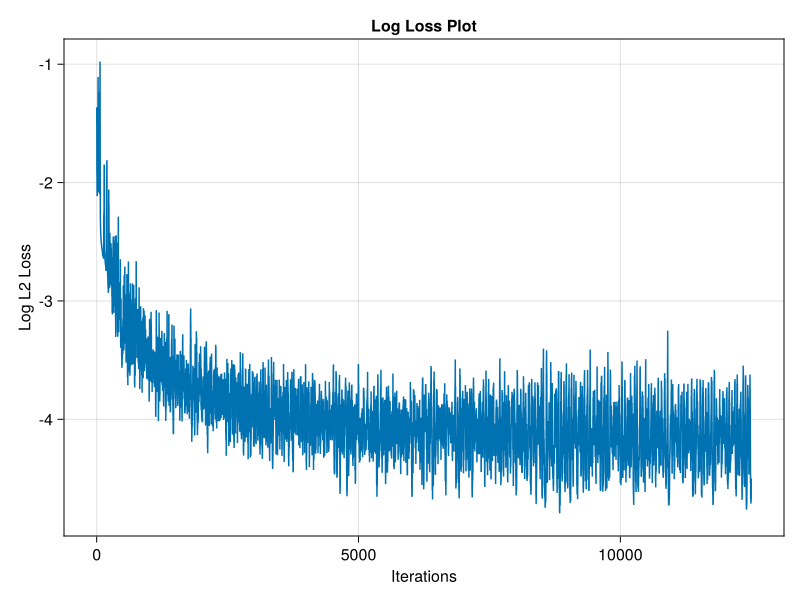

In [25]:
fig = Figure()
ax = Axis(fig[1, 1],title = "Log Loss Plot",
    xlabel = "Iterations",
    ylabel = "Log L2 Loss")
lines!(ax,log10.(Array{Float64}(my_log)))
fig

In [26]:
function get_model_control(theta)
    U = operator_to_iso_vec([1.0+0im 0; 0 1])
    x = Vector{Vector{Float64}}([[0,0]])
    v = Vector{Vector{Float64}}([[0,0]])
    accels = Vector{Vector{Float64}}()
    for t in 2:n_steps-1
        accel = Vector{Float64}(model(vcat(U,[t-1,theta])))
        push!(accels,accel)
        push!(v,v[end]+accels[end]*Δt)
        push!(x,x[end]+v[end]*Δt)
        unitary_rollout(U,hcat(accel,[0.0,0.0]),Δt,system)[:,end]
    end
    accel = (-x[end]-v[end]*Δt)/Δt^2

    push!(accels,accel)
    push!(v,v[end]+accels[end]*Δt)
    push!(x,x[end]+v[end]*Δt)
    return reduce(hcat,x),reduce(hcat,v),reduce(hcat,accels)
end

get_model_control (generic function with 1 method)

In [27]:
p.trajectory[Symbol("a"*string(1))]

2×51 Matrix{Float64}:
 0.0  -4.18361e-14  -0.014577   -0.0398214  …  -0.0240679  -0.0124064  0.0
 0.0  -1.81091e-13  -0.0138566  -0.033044       0.0482066   0.0240834  0.0

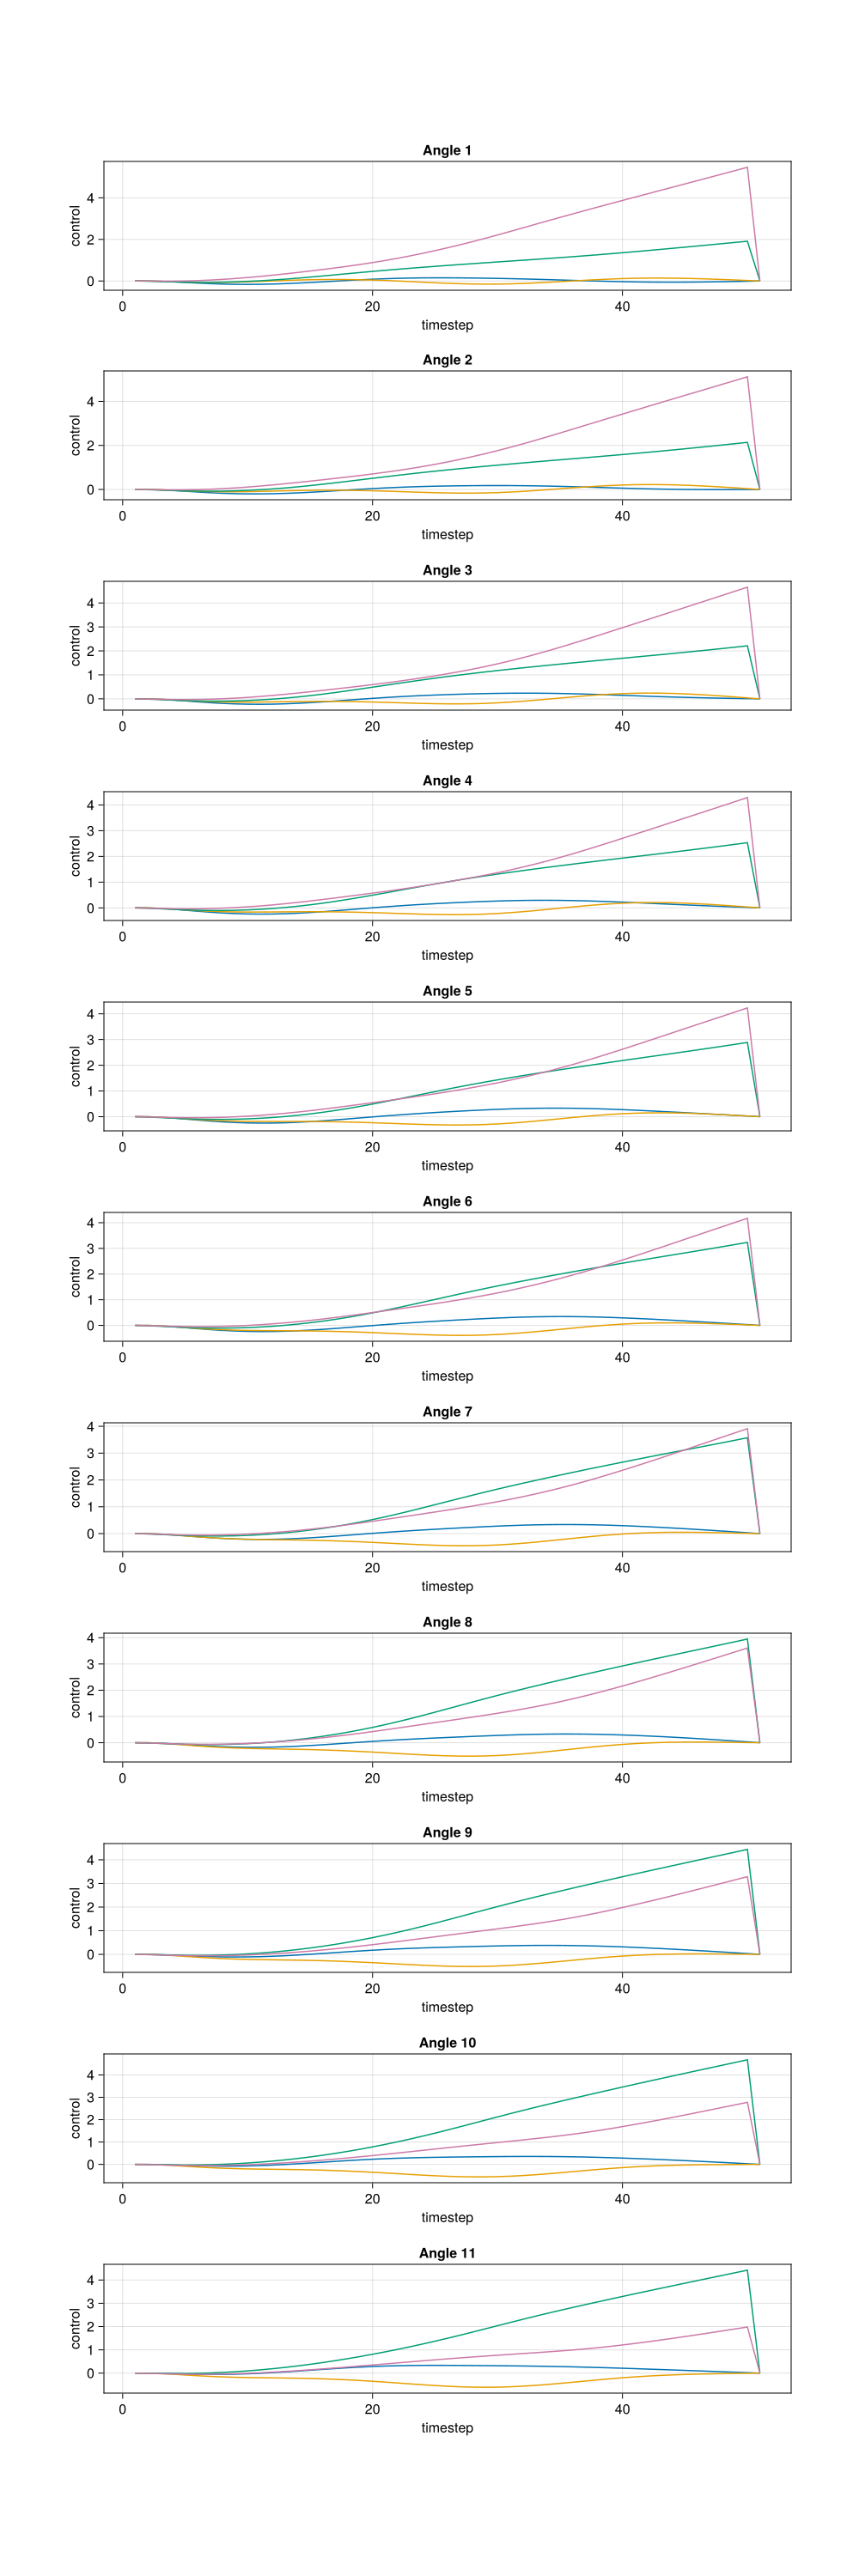

In [28]:
fig = Figure(resolution=(1000, 3000))
for (i,v) in enumerate(range(0,2*pi,N))
    ax =  Axis(fig[i,1], width = 800, height = 150, title="Angle "*string(i),xlabel="timestep",ylabel="control")
    lines!(ax,1:n_steps,p.trajectory[Symbol("a"*string(i))][1,:])
    lines!(ax,1:n_steps,p.trajectory[Symbol("a"*string(i))][2,:])
    model_x = get_model_control(v)[1]
    lines!(ax,1:n_steps,model_x[1,:])
    lines!(ax,1:n_steps,model_x[2,:])
end
fig

In [34]:
x_train[:,408]

10-element Vector{Float32}:
  0.9947687
  0.08646343
  1.8725197f-5
  0.054445103
 -0.08646343
  0.9947687
  0.054445103
 -1.8725197f-5
  8.0
  5.0265484

In [35]:
y_train[:,408]

2-element Vector{Float32}:
 0.1787724
 0.10358959

In [36]:
model(x_train[:,408])

2-element Vector{Float64}:
 0.17376498878002167
 0.10483794659376144

In [32]:
for d in data
    input, label = d

    val, grads = Flux.withgradient(model) do model
      result = model(input)
      loss(result, label)
    end
    println(val)
   end 

2.838055616211492e-5
3.22357584279744e-5
2.527126983236592e-5
2.577199844244226e-5
3.611327376372258e-5
2.0389158998009895e-5
2.6134599544079616e-5
2.1968345380847522e-5
1.590197336129055e-5
2.4832039257336364e-5
1.3889626124598185e-5
1.457826065143324e-5
1.933614313941825e-5
1.272625887921412e-5
1.631834112055158e-5
1.4583204414887433e-5
9.760445495018406e-6
3.284650745882946e-5
